# Overview

# Business Understanding

### problem and stakeholder

what is the business problem?

# Data Understanding (a lil EDA)

In [49]:
# imports
import pandas as pd
import seaborn as sns
import nltk
from nltk.probability import FreqDist
from nltk.corpus import stopwords, wordnet
from nltk.tokenize import regexp_tokenize, word_tokenize, RegexpTokenizer, TweetTokenizer
import matplotlib.pyplot as plt
import string
import re
from collections import defaultdict
import numpy as np
from imblearn.pipeline import Pipeline

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from nltk import pos_tag
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, RocCurveDisplay, confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.preprocessing import LabelEncoder, FunctionTransformer
from sklearn.dummy import DummyClassifier
from imblearn.over_sampling import SMOTE
from wordcloud import WordCloud

In [2]:
# upload the data
data = pd.read_csv('./tweet_data.csv', encoding="latin1")
data.head()

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion


In [3]:
data.tail()

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
9088,Ipad everywhere. #SXSW {link},iPad,Positive emotion
9089,"Wave, buzz... RT @mention We interrupt your re...",NaN,No emotion toward brand or product
9090,"Google's Zeiger, a physician never reported po...",NaN,No emotion toward brand or product
9091,Some Verizon iPhone customers complained their...,NaN,No emotion toward brand or product
9092,Ï¡Ïàü_ÊÎÒ£Áââ_£â_ÛâRT @...,NaN,No emotion toward brand or product


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9093 entries, 0 to 9092
Data columns (total 3 columns):
 #   Column                                              Non-Null Count  Dtype 
---  ------                                              --------------  ----- 
 0   tweet_text                                          9092 non-null   object
 1   emotion_in_tweet_is_directed_at                     3291 non-null   object
 2   is_there_an_emotion_directed_at_a_brand_or_product  9093 non-null   object
dtypes: object(3)
memory usage: 213.2+ KB


In [5]:
data.describe()

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
count,9092,3291,9093
unique,9065,9,4
top,RT @mention Marissa Mayer: Google Will Connect...,iPad,No emotion toward brand or product
freq,5,946,5389


I can see there are 4 different values for my target column all the way on the right. I wonder what those values are and their distribution.

In [3]:
data.is_there_an_emotion_directed_at_a_brand_or_product.value_counts(normalize=True)

No emotion toward brand or product    0.592654
Positive emotion                      0.327505
Negative emotion                      0.062686
I can't tell                          0.017156
Name: is_there_an_emotion_directed_at_a_brand_or_product, dtype: float64

# Data Preparation

In [7]:
# data[data['is_there_an_emotion_directed_at_a_brand_or_product'] == "No emotion toward brand or product"]

to do:

* turn target into numbers with LE()
* change "i can't tell" into "no emotion"

In [4]:
data = data[data.is_there_an_emotion_directed_at_a_brand_or_product != "I can't tell"]

In [5]:
data.is_there_an_emotion_directed_at_a_brand_or_product.value_counts(normalize=True)

No emotion toward brand or product    0.602999
Positive emotion                      0.333221
Negative emotion                      0.063780
Name: is_there_an_emotion_directed_at_a_brand_or_product, dtype: float64

In [43]:
data = data[data.is_there_an_emotion_directed_at_a_brand_or_product != "No emotion toward brand or product"]

In [45]:
data.is_there_an_emotion_directed_at_a_brand_or_product.value_counts(normalize=True)

Positive emotion    0.839346
Negative emotion    0.160654
Name: is_there_an_emotion_directed_at_a_brand_or_product, dtype: float64

In [14]:
le = LabelEncoder()

target = pd.Series(le.fit_transform(data.is_there_an_emotion_directed_at_a_brand_or_product))
le.classes_

array(['Negative emotion', 'No emotion toward brand or product',
       'Positive emotion'], dtype=object)

0 = negative
1 = no emotion
2 = positive

In [15]:
# train test split
X_train, X_test, y_train, y_test = train_test_split(data.tweet_text,
                                                    target,
                                                    random_state=42)

In [16]:
def get_wordnet_pos(treebank_tag):
    '''
    Translate nltk POS to wordnet tags
    '''
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

In [17]:
def preprocess_text(text_list, tokenizer, stopwords_list):
    
    '''
    Takes in a list of strings, a tokenizer, and list of stopwords and
    returns a list lowercased, tokenized, removes stopwords,
    and lemmatizes the words. 
    '''
    
    # lowercase
    lower = [str(text).lower() for text in text_list]
    
    # tokenize
    tokenized = [tokenizer.tokenize(tweet) for tweet in lower]
    
    # stopwords
    no_stops = []
    for item in tokenized:
        temp = []
        for token in item:
            if token not in stopwords_list:
                temp.append(token)
        no_stops.append(temp)  
    
    # preparation for lemmatization
    tags = [pos_tag(tokens) for tokens in no_stops]
    
    better_tags = []
    for item in tags:
        temp1 = []
        for word in item:
            temp1.append((word[0], get_wordnet_pos(word[1])))
        better_tags.append(temp1)

    # Lemmatization
    lemmatizer = WordNetLemmatizer()

    lem = []
    for item in better_tags:
        temp2 = []
        for word in item:
            temp2.append(lemmatizer.lemmatize(word[0], word[1]))
        lem.append(temp2)
        
    preprocessed = [' '.join(i) for i in lem]
    
    return preprocessed

In [18]:
sw = stopwords.words('english')
# regex_token = RegexpTokenizer(r"([a-zA-Z]+(?:’[a-z]+)?)")

In [19]:
class ModelWithCV():
    '''Structure to save the model and more easily see its crossvalidation'''
    
    def __init__(self, model, model_name, X, y, cv_now=True):
        self.model = model
        self.name = model_name
        self.X = X
        self.y = y
        # For CV results
        self.cv_results = None
        self.cv_mean = None
        self.cv_median = None
        self.cv_std = None
        #
        if cv_now:
            self.cross_validate()
        
    def cross_validate(self, X=None, y=None, kfolds=10):
        '''
        Perform cross-validation and return results.
        
        Args: 
          X:
            Optional; Training data to perform CV on. Otherwise use X from object
          y:
            Optional; Training data to perform CV on. Otherwise use y from object
          kfolds:
            Optional; Number of folds for CV (default is 10)  
        '''
        
        cv_X = X if X else self.X
        cv_y = y if y else self.y

        self.cv_results = cross_val_score(self.model, cv_X, cv_y, cv=kfolds)
        self.cv_mean = np.mean(self.cv_results)
        self.cv_median = np.median(self.cv_results)
        self.cv_std = np.std(self.cv_results)

        
    def print_cv_summary(self):
        cv_summary = (
        f'''CV Results for `{self.name}` model:
            {self.cv_mean:.5f} ± {self.cv_std:.5f} accuracy
        ''')
        print(cv_summary)

        
    def plot_cv(self, ax):
        '''
        Plot the cross-validation values using the array of results and given 
        Axis for plotting.
        '''
        ax.set_title(f'CV Results for `{self.name}` Model')
        # Thinner violinplot with higher bw
        sns.violinplot(y=self.cv_results, ax=ax, bw=.4)
        sns.swarmplot(
                y=self.cv_results,
                color='orange',
                size=10,
                alpha= 0.8,
                ax=ax
        )

        return ax

# Models / Evaluation

## Dummy Model

In [20]:
preprocess_step = FunctionTransformer(preprocess_text,
                                      kw_args={'tokenizer': TweetTokenizer(),
                                               'stopwords_list': sw})

dummy_pipe = Pipeline([
    ('clean', preprocess_step),
    ('vect', TfidfVectorizer()),
    ('dummy', DummyClassifier())
])

In [21]:
dummy_pipe.fit(X_train, y_train)

Pipeline(steps=[('clean',
                 FunctionTransformer(func=<function preprocess_text at 0x7fa93858f5e0>,
                                     kw_args={'stopwords_list': ['i', 'me',
                                                                 'my', 'myself',
                                                                 'we', 'our',
                                                                 'ours',
                                                                 'ourselves',
                                                                 'you',
                                                                 "you're",
                                                                 "you've",
                                                                 "you'll",
                                                                 "you'd",
                                                                 'your',
                                                                 'yours',
                                                                 'yourself',
                                                                 'yourselves',
                                                                 'he', 'him',
                                                                 'his',
                                                                 'himself',
                                                                 'she', "she's",
                                                                 'her', 'hers',
                                                                 'herself',
                                                                 'it', "it's",
                                                                 'its',
                                                                 'itself', ...],
                                              'tokenizer': <nltk.tokenize.casual.TweetTokenizer object at 0x7fa938cbae80>})),
                ('vect', TfidfVectorizer()), ('dummy', DummyClassifier())])

<AxesSubplot:title={'center':'CV Results for `dummy` Model'}>

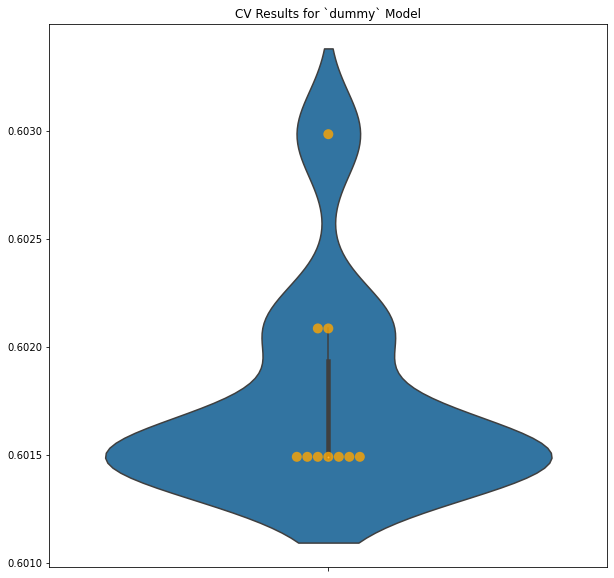

In [22]:
dummy_model = ModelWithCV(
    dummy_pipe,
    model_name = 'dummy',
    X=X_train,
    y=y_train)
fig, ax = plt.subplots(figsize=(10,10))

dummy_model.plot_cv(ax=ax)

In [23]:
dummy_model.print_cv_summary()

CV Results for `dummy` model:
            0.60176 ± 0.00047 accuracy
        


In [24]:
dummy_pipe.score(X_test, y_test)

0.6067114093959731

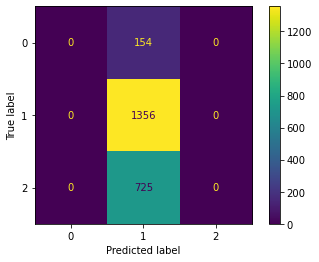

In [25]:
y_preds = dummy_pipe.predict(X_test)
cm = confusion_matrix(y_test, y_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot();

In [26]:
print(classification_report(y_test, y_preds))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       154
           1       0.61      1.00      0.76      1356
           2       0.00      0.00      0.00       725

    accuracy                           0.61      2235
   macro avg       0.20      0.33      0.25      2235
weighted avg       0.37      0.61      0.46      2235



/Users/jonniebrown/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jonniebrown/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jonniebrown/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

## Multinomial Naive Bayes

In [27]:
mnb_pipe = Pipeline([
    ('clean', preprocess_step),
    ('vect', TfidfVectorizer()),
    ('mnb', MultinomialNB())
])

In [28]:
mnb_pipe.fit(X_train, y_train)

Pipeline(steps=[('clean',
                 FunctionTransformer(func=<function preprocess_text at 0x7fa93858f5e0>,
                                     kw_args={'stopwords_list': ['i', 'me',
                                                                 'my', 'myself',
                                                                 'we', 'our',
                                                                 'ours',
                                                                 'ourselves',
                                                                 'you',
                                                                 "you're",
                                                                 "you've",
                                                                 "you'll",
                                                                 "you'd",
                                                                 'your',
                                                                 'yours',
                                                                 'yourself',
                                                                 'yourselves',
                                                                 'he', 'him',
                                                                 'his',
                                                                 'himself',
                                                                 'she', "she's",
                                                                 'her', 'hers',
                                                                 'herself',
                                                                 'it', "it's",
                                                                 'its',
                                                                 'itself', ...],
                                              'tokenizer': <nltk.tokenize.casual.TweetTokenizer object at 0x7fa938cbae80>})),
                ('vect', TfidfVectorizer()), ('mnb', MultinomialNB())])

<AxesSubplot:title={'center':'CV Results for `mnb` Model'}>

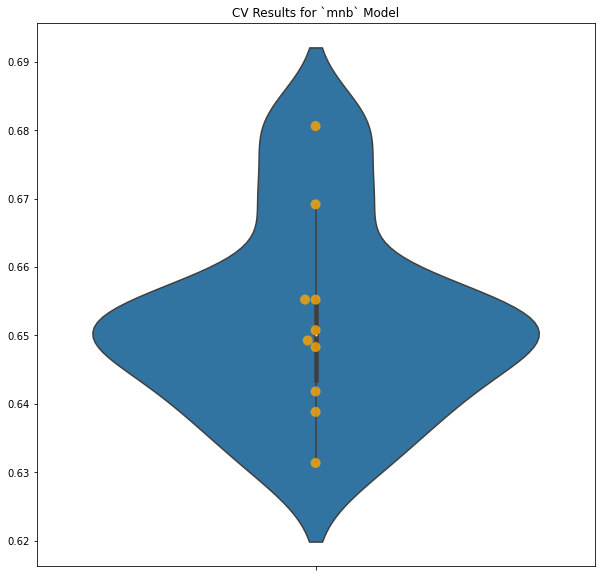

In [29]:
nb_model = ModelWithCV(
    mnb_pipe,
    model_name = 'mnb',
    X=X_train,
    y=y_train)
fig, ax = plt.subplots(figsize=(10,10))

nb_model.plot_cv(ax=ax)

In [30]:
nb_model.print_cv_summary()

CV Results for `mnb` model:
            0.65204 ± 0.01364 accuracy
        


In [31]:
mnb_pipe.score(X_test, y_test)

0.6590604026845638

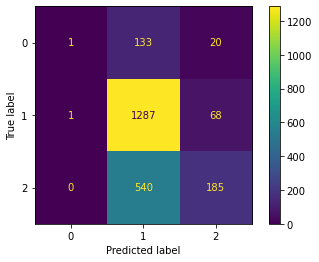

In [32]:
y_preds = mnb_pipe.predict(X_test)
cm = confusion_matrix(y_test, y_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot();

In [33]:
print(classification_report(y_test, y_preds))

              precision    recall  f1-score   support

           0       0.50      0.01      0.01       154
           1       0.66      0.95      0.78      1356
           2       0.68      0.26      0.37       725

    accuracy                           0.66      2235
   macro avg       0.61      0.40      0.39      2235
weighted avg       0.65      0.66      0.59      2235



In [ ]:
WordCloud()

## Analysis

In [48]:
prob_neg = y_train.value_counts()[0]/len(y_train)
prob_pos = y_train.value_counts()[1]/len(y_train)

In [56]:
# create df for storing words

df_index = mnb_pipe.named_steps['vect'].get_feature_names_out()
df_nbf = pd.DataFrame(index=df_index)

# Convert log probabilities to probabilities. 
df_nbf['pos'] = np.e**(mnb_pipe.named_steps['mnb'].feature_log_prob_[1, :])
df_nbf['neg'] = np.e**(mnb_pipe.named_steps['mnb'].feature_log_prob_[0, :])

 
df_nbf['odds_positive'] = (mnb_pipe.named_steps['mnb'].feature_log_prob_[0, :])/(mnb_pipe.named_steps['mnb'].feature_log_prob_[1, :])*(prob_pos /prob_neg)

df_nbf['odds_negative'] = (mnb_pipe.named_steps['mnb'].feature_log_prob_[1, :])/(mnb_pipe.named_steps['mnb'].feature_log_prob_[0, :])*(prob_neg/prob_pos )

In [62]:
# Here are the top10 most important words of your positive class:
odds_pos_top10 = df_nbf.sort_values('odds_positive',ascending=False)['odds_positive'][:10]
# Here are the top10 most important words of your negative class:
odds_neg_top10 = df_nbf.sort_values('odds_negative',ascending=False)['odds_negative'][:10]

In [63]:
odds_pos_top10

free        8.228630
win         7.580996
case        7.177138
downtown    7.070807
fun         7.020708
begin       6.992982
link        6.922799
rumor       6.876479
week        6.876479
cool        6.849484
Name: odds_positive, dtype: float64

In [64]:
odds_neg_top10

fascist     0.297087
headache    0.297087
fade        0.292968
hate        0.292968
delegate    0.288546
novelty     0.288546
tag         0.278519
solution    0.278519
among       0.269248
suck        0.269048
Name: odds_negative, dtype: float64

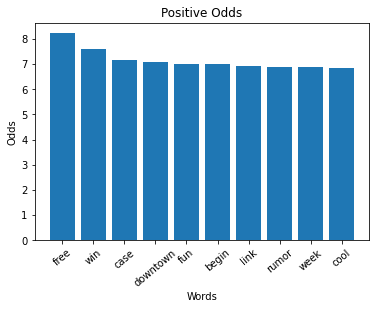

In [91]:
x=list(odds_pos_top10.index)
y=list(odds_pos_top10.values)

plt.bar(x,y)

plt.title('Positive Odds')
plt.xlabel('Words')
plt.ylabel('Odds')

plt.xticks(rotation=40)

plt.savefig('Positive_odds', dpi=800, bbox_inches='tight');


# ax.bar(x=x, y=y)

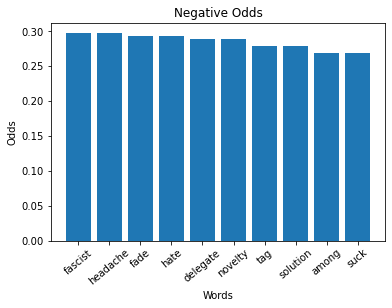

In [90]:
x=list(odds_neg_top10.index)
y=list(odds_neg_top10.values)

plt.bar(x,y)

plt.title('Negative Odds')
plt.xlabel('Words')
plt.ylabel('Odds')

plt.xticks(rotation=40)

plt.savefig('Negative Odds', dpi=800, bbox_inches='tight');


# ax.bar(x=x, y=y)

In [71]:
type(odds_pos_top10.index)

pandas.core.indexes.base.Index

In [34]:
preprocess_step = FunctionTransformer(preprocess_text,
                                      kw_args={'tokenizer': TweetTokenizer(),
                                               'stopwords_list': sw})

smote_mnb_pipe = Pipeline([
    ('clean', preprocess_step),
    ('vect', TfidfVectorizer()),
    ('smote', SMOTE()),
    ('mnb', MultinomialNB())
])

In [37]:
params = {
    'vect__max_features': [None, 10, 100, 200],
    'vect__max_df': [0.1, 0.2, 0.5, 0.75, 0.9],
    'vect__min_df': [.01, 0.05, 0.1, 0.25],
    'smote__sampling_strategy': ['minority', 'not majority']
}

In [38]:
gs = GridSearchCV(smote_mnb_pipe, param_grid=params)
gs.fit(X_train, y_train)

/Users/jonniebrown/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
120 fits failed out of a total of 800.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
40 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/jonniebrown/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/jonniebrown/anaconda3/envs/learn-env/lib/python3.8/site-packages/imblearn/pipeline.py", line 277, in fit
    Xt, yt, fit_params = self._fit(X, y, **fit_params)
  File "/Users/jonniebrown/anaconda3/envs/learn-env/lib/python3.8/site-pack

GridSearchCV(estimator=Pipeline(steps=[('clean',
                                        FunctionTransformer(func=<function preprocess_text at 0x7fa93858f5e0>,
                                                            kw_args={'stopwords_list': ['i',
                                                                                        'me',
                                                                                        'my',
                                                                                        'myself',
                                                                                        'we',
                                                                                        'our',
                                                                                        'ours',
                                                                                        'ourselves',
                                                                                        'you',
                                                                                        "you're",
                                                                                        "you've",
                                                                                        "you'll",
                                                                                        "you'd",
                                                                                        'your',
                                                                                        'yours',
                                                                                        'yourself',
                                                                                        'yourselves',
                                                                                        'he',
                                                                                        'him',
                                                                                        'his',
                                                                                        'himself',
                                                                                        'she',
                                                                                        "she's",
                                                                                        'her',
                                                                                        'hers',
                                                                                        'herself',
                                                                                        'it',
                                                                                        "it's",
                                                                                        'its',
                                                                                        'itself', ...],
                                                                     'tokenizer': <nltk.tokenize.casual.TweetTokenizer object at 0x7fa8e9614220>})),
                                       ('vect', TfidfVectorizer()),
                                       ('smote', SMOTE()),
                                       ('mnb', MultinomialNB())]),
             param_grid={'smote__sampling_strategy': ['minority',
                                                      'not majority'],
                         'vect__max_df': [0.1, 0.2, 0.5, 0.75, 0.9],
                         'vect__max_features': [None, 10, 100, 200],
                         'vect__min_df': [0.01, 0.05, 0.1, 0.25]})

In [39]:
gs.best_params_

{'smote__sampling_strategy': 'minority',
 'vect__max_df': 0.75,
 'vect__max_features': 200,
 'vect__min_df': 0.01}

In [40]:
best = gs.best_estimator_
best.score(X_test, y_test)

0.49261744966442955

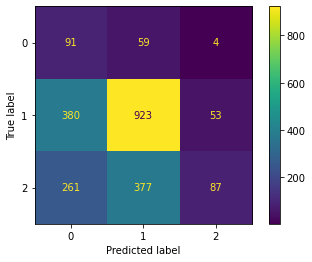

In [41]:
y_preds = best.predict(X_test)
cm = confusion_matrix(y_test, y_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot();

In [42]:
print(classification_report(y_test, y_preds))

              precision    recall  f1-score   support

           0       0.12      0.59      0.21       154
           1       0.68      0.68      0.68      1356
           2       0.60      0.12      0.20       725

    accuracy                           0.49      2235
   macro avg       0.47      0.46      0.36      2235
weighted avg       0.62      0.49      0.49      2235



In [16]:
# refined mnb
adj_mnb_pipe = Pipeline([
    ('clean', preprocess_step),
    ('vect', TfidfVectorizer(max_df=0.5, min_df=0.01)),
    ('mnb', MultinomialNB())
])

In [17]:
adj_mnb_pipe.fit(X_train, y_train)

Pipeline(steps=[('clean',
                 FunctionTransformer(func=<function preprocess_text at 0x7f9160e3bca0>,
                                     kw_args={'stopwords_list': ['i', 'me',
                                                                 'my', 'myself',
                                                                 'we', 'our',
                                                                 'ours',
                                                                 'ourselves',
                                                                 'you',
                                                                 "you're",
                                                                 "you've",
                                                                 "you'll",
                                                                 "you'd",
                                                                 'your',
                                                                 'yours',
                                                                 'yourself',
                                                                 'yourselves',
                                                                 'he', 'him',
                                                                 'his',
                                                                 'himself',
                                                                 'she', "she's",
                                                                 'her', 'hers',
                                                                 'herself',
                                                                 'it', "it's",
                                                                 'its',
                                                                 'itself', ...],
                                              'tokenizer': <nltk.tokenize.casual.TweetTokenizer object at 0x7f9170e7e4f0>})),
                ('vect', CountVectorizer(max_df=0.5, min_df=0.01)),
                ('mnb', MultinomialNB())])

In [73]:
adj_mnb_pipe.named_steps['vect'].get_feature_names_out()
# adj_mnb_pipe.named_steps["mnb"].coef_.flatten()

array(['2011', 'already', 'also', 'android', 'app', 'apple', 'apps',
       'around', 'austin', 'away', 'awesome', 'back', 'begin', 'best',
       'big', 'buy', 'call', 'case', 'check', 'circle', 'come',
       'conference', 'cool', 'could', 'day', 'design', 'downtown', 'even',
       'ever', 'every', 'everyone', 'fast', 'feature', 'find', 'first',
       'free', 'fun', 'game', 'get', 'give', 'go', 'good', 'google',
       'great', 'guy', 'hand', 'head', 'hear', 'hey', 'include', 'ipad',
       'ipad2', 'ipads', 'iphone', 'keep', 'know', 'last', 'launch',
       'life', 'like', 'line', 'link', 'live', 'll', 'long', 'look',
       'love', 'major', 'make', 'map', 'marissa', 'marketing', 'may',
       'mayer', 'mobile', 'much', 'music', 'must', 'need', 'network',
       'new', 'news', 'next', 'nice', 'one', 'open', 'panel', 'party',
       'people', 'phone', 'photo', 'place', 'pop', 'popup', 'possibly',
       'product', 're', 'really', 'release', 'right', 'rt', 'rumor',
       'save', 's

<AxesSubplot:title={'center':'CV Results for `mnb` Model'}>

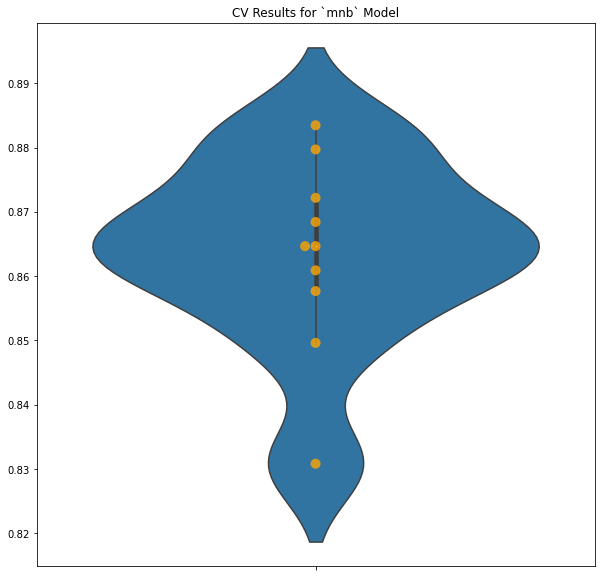

In [74]:
adj_mnb_model = ModelWithCV(
    adj_mnb_pipe,
    model_name = 'mnb',
    X=X_train,
    y=y_train)
fig, ax = plt.subplots(figsize=(10,10))

nb_model.plot_cv(ax=ax)

In [75]:
adj_mnb_model.print_cv_summary()

CV Results for `mnb` model:
            0.80496 ± 0.02824 accuracy
        


In [76]:
adj_mnb_pipe.score(X_test, y_test)

0.8038331454340474

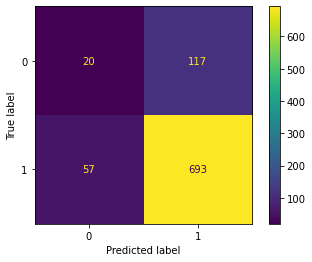

In [77]:
y_preds = adj_mnb_pipe.predict(X_test)
cm = confusion_matrix(y_test, y_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot();

In [78]:
print(classification_report(y_test, y_preds))

              precision    recall  f1-score   support

           0       0.26      0.15      0.19       137
           1       0.86      0.92      0.89       750

    accuracy                           0.80       887
   macro avg       0.56      0.53      0.54       887
weighted avg       0.76      0.80      0.78       887



In [ ]:
def get_salient_words(nb_clf, class_ind):
    """Return salient words for given class
    Parameters
    ----------
    nb_clf : a Naive Bayes classifier (e.g. MultinomialNB, BernoulliNB)
    class_ind : int
    Returns
    -------
    list
        a sorted list of (word, log prob) sorted by log probability in descending order.
    """

    words = adj_mnb_pipe.named_steps['vect'].get_feature_names_out()
    zipped = list(zip(words, nb_clf.feature_log_prob_[class_ind]))
    sorted_zip = sorted(zipped, key=lambda t: t[1], reverse=True)

    return sorted_zip

neg_salient_top_20 = get_salient_words(adj_mnb_pipe, 0)[:20]
pos_salient_top_20 = get_salient_words(adj_mnb_pipe, 1)[:20]

In [41]:
# looking for top 10 features
mnb_pipe10 = Pipeline([
    ('clean', preprocess_step),
    ('vect', CountVectorizer(max_features=10)),
    ('mnb', MultinomialNB())
])

In [42]:
mnb_pipe10.fit(X_train, y_train)

Pipeline(steps=[('clean',
                 FunctionTransformer(func=<function preprocess_text at 0x7f9160e3bca0>,
                                     kw_args={'stopwords_list': ['i', 'me',
                                                                 'my', 'myself',
                                                                 'we', 'our',
                                                                 'ours',
                                                                 'ourselves',
                                                                 'you',
                                                                 "you're",
                                                                 "you've",
                                                                 "you'll",
                                                                 "you'd",
                                                                 'your',
                                                                 'yours',
                                                                 'yourself',
                                                                 'yourselves',
                                                                 'he', 'him',
                                                                 'his',
                                                                 'himself',
                                                                 'she', "she's",
                                                                 'her', 'hers',
                                                                 'herself',
                                                                 'it', "it's",
                                                                 'its',
                                                                 'itself', ...],
                                              'tokenizer': <nltk.tokenize.casual.TweetTokenizer object at 0x7f9170e7e4f0>})),
                ('vect', CountVectorizer(max_features=10)),
                ('mnb', MultinomialNB())])

In [89]:
top10 = mnb_pipe10.named_steps['vect'].get_feature_names_out()
top10

array(['app', 'apple', 'google', 'ipad', 'iphone', 'link', 'mention',
       'rt', 'store', 'sxsw'], dtype=object)

# stop looking here

### Top 10 Words

In [151]:
cv = CountVectorizer(max_features=10)
X_t_vec = cv.fit_transform(X_t)
X_t_vec  = pd.DataFrame.sparse.from_spmatrix(X_t_vec)
X_t_vec.columns = sorted(cv.vocabulary_)
X_t_vec.set_index(y_t.index, inplace=True)


X_val_vec = cv.transform(X_val)
X_val_vec  = pd.DataFrame.sparse.from_spmatrix(X_val_vec)
X_val_vec.columns = sorted(cv.vocabulary_)
X_val_vec.set_index(y_val.index, inplace=True)

In [152]:
# how many words is the model looking at?
len(cv.vocabulary_)

10

In [153]:
X_t_vec

,apple,google,ipad,iphone,link,mention,quot,rt,store,sxsw
4241,0,0,0,1,0,1,0,1,0,1
1930,0,1,0,0,0,0,0,0,0,1
3171,0,0,0,1,0,0,0,0,0,1
8572,0,0,1,0,0,0,0,0,0,1
5598,0,0,0,1,0,2,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...
8380,0,0,0,0,0,1,0,0,0,2
145,1,0,1,0,0,2,0,0,0,1
1804,0,1,0,0,0,0,0,0,0,1
2866,1,0,0,0,1,1,0,1,0,1


I don't think these top 10 words are going to be very helpful. I might consider adding some of them to the stopwords list.

In [120]:
nb = MultinomialNB().fit(X_t_vec, y_t)

In [121]:
nb.score(X_val_vec, y_val)

0.5978520286396182

### Top 100 Words

In [164]:
cv = CountVectorizer(max_features=100)
X_t_vec = cv.fit_transform(X_t)
X_t_vec  = pd.DataFrame.sparse.from_spmatrix(X_t_vec)
X_t_vec.columns = sorted(cv.vocabulary_)
X_t_vec.set_index(y_t.index, inplace=True)


X_val_vec = cv.transform(X_val)
X_val_vec  = pd.DataFrame.sparse.from_spmatrix(X_val_vec)
X_val_vec.columns = sorted(cv.vocabulary_)
X_val_vec.set_index(y_val.index, inplace=True)

In [165]:
# how many words is the model looking at?
len(cv.vocabulary_)

100

In [166]:
X_t_vec

,amp,android,app,apple,apps,around,austin,awesome,best,big,...,tweet,update,use,user,via,want,win,work,would,year
4241,0,0,1,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
1930,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3171,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8572,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5598,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8380,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
145,0,0,0,1,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
1804,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2866,0,0,0,1,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [116]:
nb = MultinomialNB().fit(X_t_vec, y_t)

In [117]:
nb.score(X_val_vec, y_val)

0.5948687350835322

### Top 200 Words

In [122]:
cv = CountVectorizer(max_features=200)
X_t_vec = cv.fit_transform(X_t)
X_t_vec  = pd.DataFrame.sparse.from_spmatrix(X_t_vec)
X_t_vec.columns = sorted(cv.vocabulary_)
X_t_vec.set_index(y_t.index, inplace=True)


X_val_vec = cv.transform(X_val)
X_val_vec  = pd.DataFrame.sparse.from_spmatrix(X_val_vec)
X_val_vec.columns = sorted(cv.vocabulary_)
X_val_vec.set_index(y_val.index, inplace=True)

In [123]:
# how many words is the model looking at?
len(cv.vocabulary_)

200

In [124]:
nb = MultinomialNB().fit(X_t_vec, y_t)

In [125]:
nb.score(X_val_vec, y_val)

0.6026252983293556

### Minimum Document Frequency of 5%

In [173]:
cv = CountVectorizer(min_df=.05, max_df=0.5)
X_t_vec = cv.fit_transform(X_t)
X_t_vec  = pd.DataFrame.sparse.from_spmatrix(X_t_vec)
X_t_vec.columns = sorted(cv.vocabulary_)
X_t_vec.set_index(y_t.index, inplace=True)


X_val_vec = cv.transform(X_val)
X_val_vec  = pd.DataFrame.sparse.from_spmatrix(X_val_vec)
X_val_vec.columns = sorted(cv.vocabulary_)
X_val_vec.set_index(y_val.index, inplace=True)

In [174]:
# how many words is the model looking at?
len(cv.vocabulary_)

21

In [175]:
X_t_vec

,amp,android,app,apple,austin,circle,get,google,ipad,iphone,...,link,network,new,open,pop,quot,rt,social,store,today
4241,0,0,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,1,0,0,0
1930,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3171,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
8572,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
5598,0,0,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8380,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
145,0,0,0,1,0,0,0,0,1,0,...,0,0,1,0,0,0,0,0,0,0
1804,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2866,0,0,0,1,1,0,0,0,0,0,...,1,0,0,1,0,0,1,0,0,0


In [128]:
nb = MultinomialNB().fit(X_t_vec, y_t)

In [129]:
nb.score(X_val_vec, y_val)

0.5865155131264916

### Minimum Document Frequency of 2%

In [130]:
cv = CountVectorizer(min_df=0.02)
X_t_vec = cv.fit_transform(X_t)
X_t_vec  = pd.DataFrame.sparse.from_spmatrix(X_t_vec)
X_t_vec.columns = sorted(cv.vocabulary_)
X_t_vec.set_index(y_t.index, inplace=True)


X_val_vec = cv.transform(X_val)
X_val_vec  = pd.DataFrame.sparse.from_spmatrix(X_val_vec)
X_val_vec.columns = sorted(cv.vocabulary_)
X_val_vec.set_index(y_val.index, inplace=True)

In [131]:
# how many words is the model looking at?
len(cv.vocabulary_)

61

In [132]:
nb = MultinomialNB().fit(X_t_vec, y_t)

In [133]:
nb.score(X_val_vec, y_val)

0.5894988066825776

## Random Forest Model

In [156]:
cv = CountVectorizer()
X_t_vec = cv.fit_transform(X_t)
X_t_vec  = pd.DataFrame.sparse.from_spmatrix(X_t_vec)
X_t_vec.columns = sorted(cv.vocabulary_)
X_t_vec.set_index(y_t.index, inplace=True)


X_val_vec = cv.transform(X_val)
X_val_vec  = pd.DataFrame.sparse.from_spmatrix(X_val_vec)
X_val_vec.columns = sorted(cv.vocabulary_)
X_val_vec.set_index(y_val.index, inplace=True)

In [135]:
rf = RandomForestClassifier().fit(X_t_vec, y_t)

<AxesSubplot:title={'center':'CV Results for `rf` Model'}>

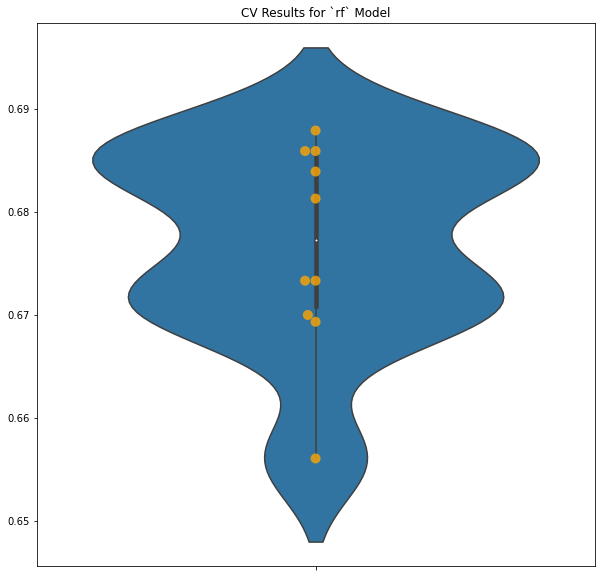

In [136]:
rf_model = ModelWithCV(
    rf,
    model_name = 'rf',
    X=X_t_vec,
    y=y_t)
fig, ax = plt.subplots(figsize=(10,10))

rf_model.plot_cv(ax=ax)

In [137]:
rf_model.print_cv_summary()

CV Results for `rf` model:
            0.67668 ± 0.00956 accuracy
        


In [138]:
rf.score(X_val_vec, y_val)

0.6694510739856802

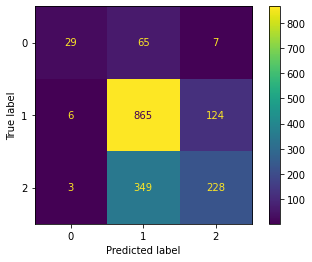

In [139]:
y_preds = rf.predict(X_val_vec)
cm = confusion_matrix(y_val, y_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot();

In [140]:
print(classification_report(y_val, y_preds))

              precision    recall  f1-score   support

           0       0.76      0.29      0.42       101
           1       0.68      0.87      0.76       995
           2       0.64      0.39      0.49       580

    accuracy                           0.67      1676
   macro avg       0.69      0.52      0.55      1676
weighted avg       0.67      0.67      0.64      1676



### Random Forest with gridsearch

In [143]:
rf = RandomForestClassifier()

param_grid = {
    'n_estimators': [100, 500, 1000],
    'max_depth': [2, 5, 10],
    'min_samples_split': [2, 5, 10]
}

gs_rf = GridSearchCV(rf, param_grid, cv=3)
gs_rf.fit(X_t_vec, y_t)

gs_rf.best_params_

{'max_depth': 10, 'min_samples_split': 10, 'n_estimators': 100}

<AxesSubplot:title={'center':'CV Results for `gs_rf_model` Model'}>

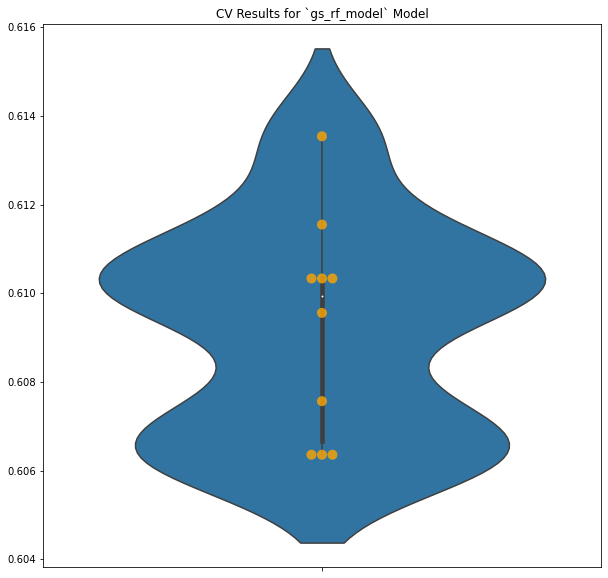

In [146]:
gs_rf_model = ModelWithCV(
    gs_rf.best_estimator_,
    model_name = 'gs_rf_model',
    X=X_t_vec,
    y=y_t)
fig, ax = plt.subplots(figsize=(10,10))

gs_rf_model.plot_cv(ax=ax)

In [148]:
rf_model.print_cv_summary()

CV Results for `rf` model:
            0.67668 ± 0.00956 accuracy
        


In [145]:
gs_rf.best_score_

0.6088337548534178

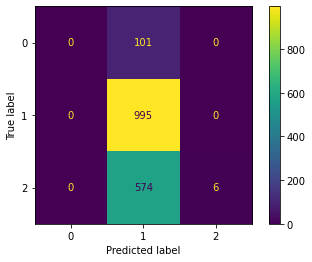

In [149]:
best_gs = gs_rf.best_estimator_
y_preds = best_gs.predict(X_val_vec)
cm = confusion_matrix(y_val, y_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot();

In [150]:
print(classification_report(y_val, y_preds))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       101
           1       0.60      1.00      0.75       995
           2       1.00      0.01      0.02       580

    accuracy                           0.60      1676
   macro avg       0.53      0.34      0.26      1676
weighted avg       0.70      0.60      0.45      1676



/Users/jonniebrown/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jonniebrown/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jonniebrown/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

maybe the data needs to be more balanced?

In [48]:
from imblearn.over_sampling import SMOTE

In [119]:
textclassifier =Pipeline([
  ('vect', CountVectorizer()),
   ('smote', SMOTE(random_state=42)),
   ('mnb', MultinomialNB())
])

In [120]:
textclassifier.fit(X_t, y_t)

Pipeline(steps=[('vect', CountVectorizer()), ('smote', SMOTE(random_state=42)),
                ('mnb', MultinomialNB())])

In [121]:
textclassifier.score(X_val, y_val)

0.6020286396181385

In [122]:
textclassifier.predict(["I'm so angry"])

array([0])

In [123]:
textclassifier.predict(["I love this product so much because it makes me happy"])

array([2])

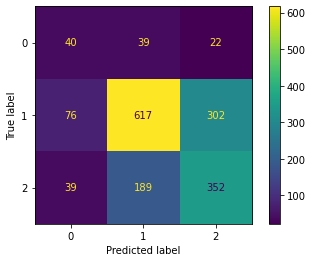

In [124]:
y_preds = textclassifier.predict(X_val)
cm = confusion_matrix(y_val, y_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot();

Maybe I need to adjust the stop words?

In [105]:
adjusted_sw = sw + ['apple', 'google', 'ipad', 'iphone']

In [106]:
type(adjusted_sw)

list

In [108]:
sw[-10:]

['shouldn',
 "shouldn't",
 'wasn',
 "wasn't",
 'weren',
 "weren't",
 'won',
 "won't",
 'wouldn',
 "wouldn't"]

In [109]:
adjusted_sw[-10:]

['weren',
 "weren't",
 'won',
 "won't",
 'wouldn',
 "wouldn't",
 'apple',
 'google',
 'ipad',
 'iphone']

In [110]:
# train test split
X_train, X_test, y_train, y_test = train_test_split(data.tweet_text,
                                                    target,
                                                    random_state=42)

In [111]:
X_train = preprocess_text(X_train, regex_token, adjusted_sw)

In [112]:
# Secondary train-test split to build our best model
X_t, X_val, y_t, y_val = train_test_split(X_train, y_train, random_state=42)

### trying different vectorizer

In [40]:
tf_idf = TfidfVectorizer(max_features=100)
X_t_vec = tf_idf.fit_transform(X_t)
X_t_vec  = pd.DataFrame.sparse.from_spmatrix(X_t_vec)
X_t_vec.columns = sorted(tf_idf.vocabulary_)
X_t_vec.set_index(y_t.index, inplace=True)


X_val_vec = tf_idf.transform(X_val)
X_val_vec  = pd.DataFrame.sparse.from_spmatrix(X_val_vec)
X_val_vec.columns = sorted(tf_idf.vocabulary_)
X_val_vec.set_index(y_val.index, inplace=True)

In [41]:
# how many words is the model looking at?
len(tf_idf.vocabulary_)

100

In [42]:
X_t_vec

,amp,android,app,apple,apps,around,austin,awesome,best,big,...,update,use,user,via,video,want,win,work,would,year
4241,0.0,0.000000,0.499276,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.642105,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1930,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3171,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8572,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5598,0.0,0.000000,0.576342,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8380,0.0,0.459014,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
145,0.0,0.000000,0.000000,0.242955,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1804,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2866,0.0,0.000000,0.000000,0.228626,0.0,0.0,0.309097,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


I don't think these top 10 words are going to be very helpful. I might consider adding some of them to the stopwords list.

In [43]:
nb = MultinomialNB().fit(X_t_vec, y_t)

In [44]:
nb.score(X_val_vec, y_val)

0.6193317422434368

# Conclusion